In [1]:
import time

import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.optim import Adam

from framework.agents import DQNAgent
from pendulum import PendulumEnvironment, PendulumState, PendulumRenderer
from shared_parameters import *
from utils import MemoryBuffer, running_average, mean

torch.set_printoptions(sci_mode=False)

In [2]:
env = PendulumEnvironment(bob_radius, max_angle, connector_length, vertical_speed, angular_speed, enemy_radius,
                          enemy_x_min, enemy_x_max, enemy_y, step_reward=1.0, action_reward=-0.1, death_reward=-100.0,
                          time_scale=5)
max_episode_length = 20

num_actions = 2
agent = DQNAgent(PendulumState.get_size(1), action_size=num_actions, hidden=[6, 8, 4], memory_capacity=10000,
                 optimizer_class=Adam, lr=0.01, polyak_factor=0.95, epsilon_steps=1000, discount_factor=0.995,
                 training_sample_size=500)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

# Default starting state
total_rewards = []

def play_episode(render=False):
    # Randomize enemy position
    state = env.get_starting_state()
    total_reward = 0
    for _ in range(max_episode_length):
        if render:
            renderer.render(state)
            time.sleep(0.016 * 5)
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

    return total_reward

try:
    loss = agent.train(env, 1, 20, verbose=True)
    print(loss)
except KeyboardInterrupt:
    ...

Epoch 1/1. Loss: 421.36469
421.36468505859375


loss: 101.85635, average reward: -2.8855999999999944, epsilon: 0.1000


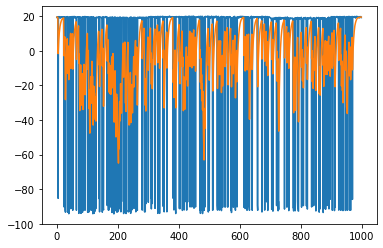

In [131]:
try:
    loss = agent.train(env, 100, 20)
    for i in range(100):
        play_episode()

    clear_output(wait=True)
    print(f"loss: {loss:.5f}, average reward: {mean(total_rewards)}, epsilon: {agent.epsilon.value:.4f}")
    plt.plot(total_rewards)
    plt.plot(running_average(total_rewards))
    plt.show()
except KeyboardInterrupt:
    ...

Once we're satisfied with the quality of our Q-network,
we can use it to infer the difficulty of the environment.

    Actually, we can also infer the difficulty without a trained Q-netwrok,
    the only difference is the quality of predictions. Untrained Q-network
    can (but not always) behave as an agent who does not know how to play the game.

Let's now estimate the difficulty of a single episode:

1. The difficulty of an episode is an aggregated difficulty of the individual states
2. The difficulty of a state is the difference between the maximum Q-value, from the
   average of the Q-values of the state

We also need to keep the Q-values normalized. The normalization occurs w.r.t. the
maximum and minimum Q-values, experienced by a single agent with its own Q-network.

In [ ]:
# Initialize the minimum and maximum Q-values
q_min, q_max = float("inf"), float("-inf")

In [ ]:
episode = play_episode(verbose=True, render=False, train=False, use_epsilon=False, push_into_memory=False)
print()

states, *_ = zip(*episode)
states = torch.tensor(states)

with torch.no_grad():
    q_values = agent.get_q_values(states)

    print("Q-values")
    print(q_values)
    print()

    # Update the bounds
    q_min = min(q_min, q_values.min())
    q_max = max(q_max, q_values.max())

    # Normalize
    q_values = (q_values - q_min) / (q_max - q_min)

    print("Q-values (normalized)")
    print(q_values)
    print()

    difficulties = q_values.max(dim=-1)[0] - q_values.mean(dim=-1)

    print("Difficulties")
    print(difficulties)
    print()

    trajectory_difficulty = difficulties.mean()
    print(f"Trajectory difficulty = {trajectory_difficulty:.6f}")

We can now use this as another method of difficulty estimation